In [230]:
import numpy as np

import matplotlib.pyplot as plt
from controllers import DeePC, DDeePC
import gym
from tqdm import tqdm
from IPython import display
import torch
import torch.optim as optim

plt.rcParams["figure.figsize"] = (15,8)

%matplotlib inline
%reload_ext autoreload
%autoreload 

In [231]:
Tini = 1 # 1 for Ud and 5 for Ud2
n = 4
N = 20 # 30 for Ud2 and 20 for Ud
m = 1
p = 4
T = (m+1)*(Tini + N + n) + 10 # 10 for Ud and 22 for Ud2
T

60

In [232]:
from numpy import genfromtxt
ud = genfromtxt('Ud.csv', delimiter=',')
yd = genfromtxt('Yd.csv', delimiter=',') #+ np.random.randn(T*p)*0.01
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

yd shape : (240,)   ud shape : (60,)


In [233]:
y_const = torch.kron(torch.ones(N), torch.Tensor([0.02,0.01,0.05,0.1]))
u_const = torch.ones(N)*3
r = torch.ones(N*m).to(device='mps')
q = torch.ones(N*p).to(device='mps')*100
lam_y = 1e9
lam_g1 = torch.Tensor([100]).to(device='mps')
lam_g2 = torch.Tensor([100]).to(device='mps')

controller = DDeePC(
    ud=ud, yd=yd, T=T, p=p, m=m, n_batch=1, N=N, Tini=Tini,
    y_constraints=y_const, u_constraints=u_const,
    stochastic=False, linear=False, q=q, r=r, lam_g1=lam_g1, lam_g2=lam_g2
).to(device='mps')

In [234]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
done = False
render = False
iter = 500
num_epochs = 200

for epoch in range(num_epochs):

    pbar = tqdm(range(iter))
    u_ini = ud[:m*Tini].reshape((Tini*m,))
    y_ini = yd[:p*Tini].reshape((Tini*p,))
    yT = [*y_ini]
    uT = [*u_ini]
    ref = torch.zeros(N*p).to(device='mps')

    for i in pbar:
        pbar.set_description(f'epoch : {epoch}')
        # Solve for optimal input
        input, _ = controller(ref=ref, y_ini=torch.Tensor(y_ini).to(device='mps'), u_ini=torch.Tensor(u_ini).to(device='mps'))
        action = input[:m].cpu().detach().numpy()
        # roll simulation forward
        obs, _ ,done,_,_ = env.step(action)
        if done : break
        yT = np.append(yT, obs)
        uT = np.append(uT, action)
        
        # Render gym env
        if render:
            plt.title(f"Action {action[0]:.4f}N, X {obs[0]:.3f}m, Theta {obs[1]:.3f} rad Iter {iter}")
            plt.imshow(env.render())
            display.display(plt.gcf())    
            display.clear_output(wait=True)

        # Reset initial conditions
        u_ini = uT[-Tini:]
        y_ini = yT[-p*Tini:]
    
    


epoch : 0:   0%|          | 0/500 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/diffcp/cone_program.py:295: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
epoch : 0: 100%|██████████| 500/500 [01:54<00:00,  4.37it/s]


In [235]:
uT = uT[Tini*m:]
yT = yT[Tini*p:]
T = len(uT)
yT = yT.reshape((T,p))
uT = uT.reshape((T,m))

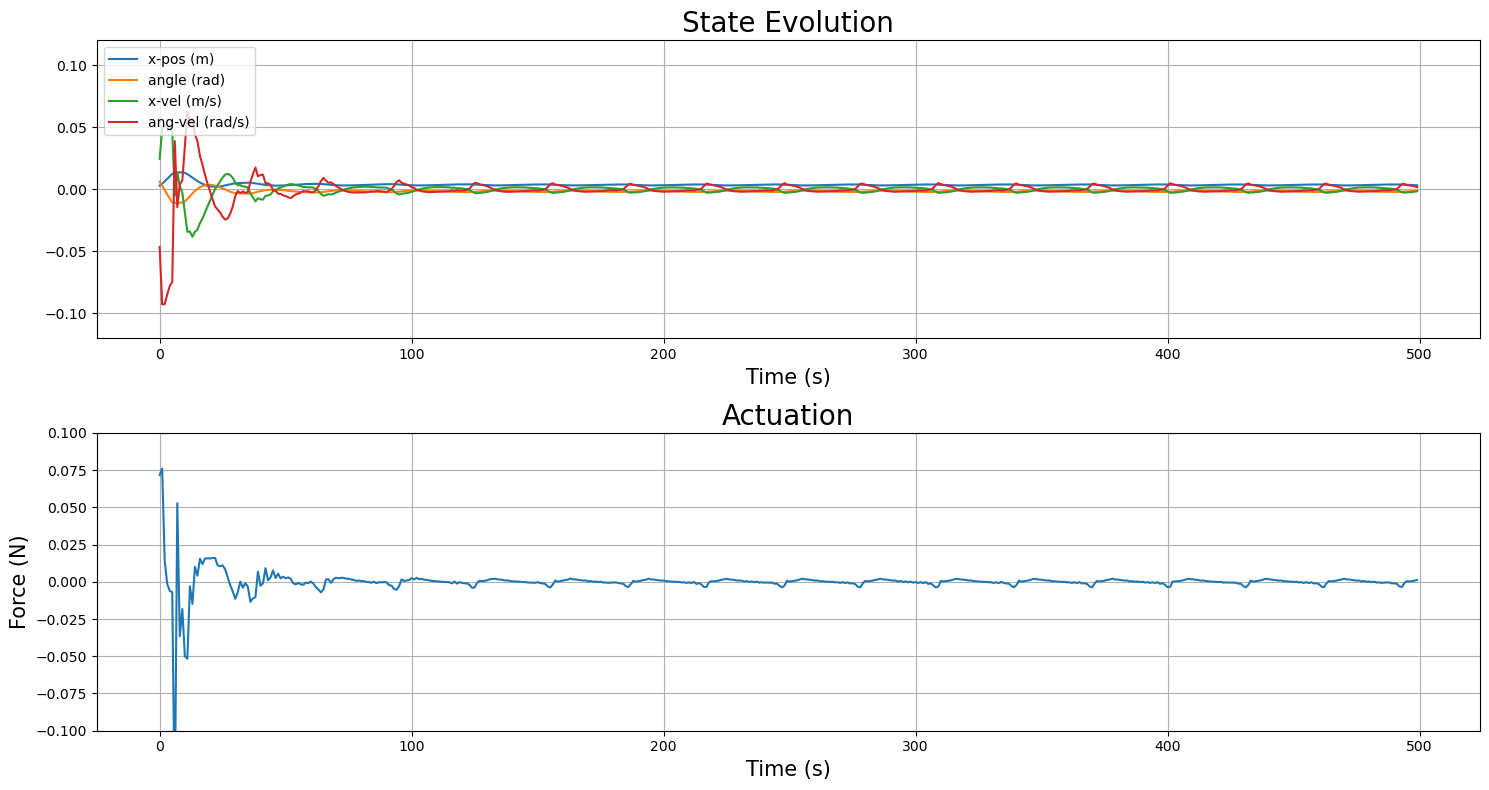

In [236]:
plt.subplot(2,1,1)
plt.plot(range(0,T), yT, label=['x-pos (m)', 'angle (rad)', 'x-vel (m/s)', 'ang-vel (rad/s)'])
# plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='Terminal Constraints')
# plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
# plt.plot(range(0,T), np.ones(T)*0.05, 'r--',label='Constraints')
# plt.plot(range(0,T), -np.ones(T)*0.05, 'r--')
plt.legend(loc="upper left")
plt.ylim((-0.12,0.12))
plt.xlabel('Time (s)', fontdict={'fontsize':15})
plt.title("State Evolution", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(range(0,T), uT)
plt.ylabel('Force (N)', fontdict={'fontsize':15})
plt.xlabel('Time (s)', fontdict={'fontsize':15})
plt.title("Actuation", fontdict={'fontsize':20})
plt.ylim((-0.1,0.1))
plt.grid('on')
plt.tight_layout()

plt.show()

In [237]:
for param in controller.parameters():
    print(param)